# **BiotrAIn 2025 Tutorial: Beta diversity **

# Section 02: Comparing microbial community structures by Unifrac Beta diversity

- Time: 14:00 - 15:00 EDT, Jul 11, 2025

Welcome to the practical session 02. created by professor Qiyun Zhu and adapted by Nelly Selem (Secodment host), Jeanett Daga (Secodment).


🏆 QUESTIONS

?

🎯 AIMS

1.   To
2.   To

🔑 KEY POINTS


*   
*
---
📥 **Input:

Latino America Shotgun data from EMP500 project
  latam_ogu.biom
  latam_ogu.tax
  latam_ogu.nwk
  latam_samples.tsv

📤 Output:

## Background

In this workshop section, we will focus on beta-diversity using UniFrac, on the shotgun data from the EMP500 dataset. We will apply UniFrac which is a popular phylogenetic beta-diversity metric. The similarity computed is the **uni**que **frac**tion of the phylogenetic branch length between a pair of samples. Then, we will perform Principal Coordinates Analysis to visualize the primary axes of variation among samples. We will then apply PERMANOVA to test for significant differences among groups of samples.

Last, to further explore the capabilities of scikit-bio, we will  test whether sample similarities are correlated between two prevalent phyla using both a Mantel test and Procrustes analysis.

## Learning objectives

In this section of the workshop, you will learn how to:

* Filter and rarefy a feature table
* Run UniFrac programmatically
* Apply Principal Coordinates Analysis, and visualize the resulting coordinates
* Perform PERMANOVA,
Extra material
* Use the TreeNode to identify common phyla, and constrain subsequent analyses based on the subtrees
* Perform Mantel and Procustes tests

## Preparation

Install the latest version of scikit-bio if it hasn't been (needed for every Google Colab instance).

In [ ]:
from importlib.util import find_spec

In [ ]:
if find_spec('skbio') is None:
    !pip install -q scikit-bio

In [ ]:
import skbio
skbio.__version__

'0.6.3'

Import Matplotlib for plotting.

In [ ]:
import matplotlib.pyplot as plt

Mute warnings.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

Next, we're going to load the feature table into the `Table` object. Often, feature tables are quite sparse -- in the American Gut Project, we observe < .1% of values in a feature table are non-zero. To account for the sparsity, this object represents the matrix of sample / feature counts using a sparse matrix representation which only stores the non-zero data. Like the `TreeNode`, the `Table` object has a rich set of methods for filtering, transforming, collapsing, partitioning, subsampling (i.e., rarefaction) and more.

In [ ]:
from skbio import Table

In [ ]:
tableShotgun = Table.read(f'https://github.com/nselem/biotraintemp/raw/refs/heads/main/data/shotgun/latam_ogu.biom')
tableShotgun

14933 x 68 <class 'biom.table.Table'> with 90562 nonzero entries (8% dense)

In [ ]:
# prompt: imprimir los primeros renglones de tableShotgun
print(tableShotgun.head())


# Constructed from biom file
#OTU ID	13114.jensen.43.s012	13114.jensen.43.s013	13114.jensen.43.s014	13114.pinto.63.s001	13114.pinto.63.s002
G000005825	0.0	0.0	0.0	0.0	0.0
G000006175	0.0	0.0	0.0	0.0	0.0
G000006605	0.0	0.0	0.0	0.0	0.0
G000006725	0.0	1.0	0.0	0.0	0.0
G000006745	0.0	0.0	0.0	0.0	0.0


Before we can do anything exciting, we need to load the various pieces of data into memory.

First, we're going to load the phylogeny into the `TreeNode` object. A `TreeNode` provides a rich set of methods for interacting with phylogeny, including operations to traverse, compare trees, aggregate information, collect subtrees and more. Later on in the Notebook, we will show an example of aggregating information up a tree, following by collecting tips from specific clades.

In [ ]:
from skbio import TreeNode

In [ ]:
github_data_path = "https://raw.githubusercontent.com/nselem/biotraintemp/refs/heads/main/data/"
latamtree_path = github_data_path + "shotgun/latam_ogu.nwk"
phylogeny = skbio.TreeNode.read(latamtree_path, format='newick')
phylogeny

<TreeNode, name: N1, internal node count: 14326, tips count: 14933>

Last, we will load the sample metadata, which has been discussed in prior sections. We will focus on the `empo_1` category which describes whether a sample is host associated or environmental, so we'll pull that column out upfront.

In [ ]:
from skbio import SampleMetadata
import pandas as pd

In [ ]:
#metadata = SampleMetadata.load(f'{HOME}/sample.tsv')
latamMeta_path = github_data_path + "latam/latam_samples.tsv"
latamMeta_path
# Read the TSV file directly from the URL into a pandas DataFrame
LatamMeta_df = pd.read_csv(latamMeta_path, sep='\t', low_memory=False, index_col='sample_name')

metadata = SampleMetadata(LatamMeta_df, default_missing_scheme='INSDC:missing')
#metadata

In [ ]:
empo_1 = metadata.get_column('empo_1').to_series()
empo_1

,empo_1
sample_name,
13114.jensen.43.s012,Free-living
13114.jensen.43.s013,Free-living
13114.jensen.43.s014,Free-living
13114.pinto.62.s001,Free-living
13114.pinto.62.s002,Free-living
...,...
13114.zaneveld.9.s006,Host-associated
13114.zaneveld.9.s010,Host-associated
13114.zaneveld.9.s011,Host-associated


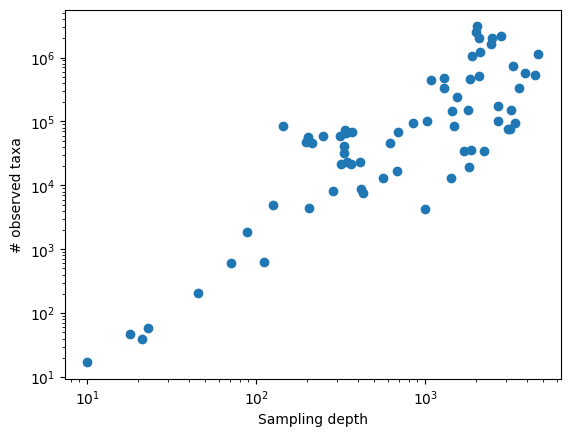

In [ ]:
from scipy.stats import describe
from skbio.diversity import alpha_diversity
res = alpha_diversity('sobs', tableShotgun)
res
plt.figure()
plt.scatter(res, tableShotgun.sum('sample'))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Sampling depth')
plt.ylabel('# observed taxa');

## Rarefaction

UniFrac is sensitive to uneven sequencing effort among samples. To account for this, we will rarefy the table a single time. In interests of simplifying compute in the tutorial, we will rarefy to a fairly shallow level of 100 sequences per sample. However, as we will see, this shallow depth is still sufficient to differentiate a high effect size variable like whether a sample is host associated or environmental.

**NOTE**: Not all diversity calculations are sensitive to sequencing depth. However, with those other metrics such as [RPCA](https://journals.asm.org/doi/10.1128/msystems.00016-19) and [Phylo-PRCA](https://journals.asm.org/doi/10.1128/msystems.00050-22) it may still be important to remove samples with too few sequences.



In [ ]:
depth = 100
even_table = tableShotgun.subsample(depth)

While not strictly necessary, we will remove unnecessary vertices and edges from the phylogeny relative to the rarefied table. Doing so reduces the compute for UniFrac later on.

**NOTE**: scikit-bio is the reference implementation for [Fast UniFrac](https://www.nature.com/articles/ismej200997). However, subsequent large [algorithmic improvements](https://journals.asm.org/doi/10.1128/msystems.00028-22) have been developed. This advanced variant will be included directly in scikit-bio in the future.

In [ ]:
even_phylogeny = phylogeny.shear(set(even_table.ids(axis='observation')))

## UniFrac distance

Let's go ahead and run UniFrac now.

If you're unfamiliar with UniFrac, it is a [distance metric](https://www.nature.com/articles/ismej2010133) that computes a distance between two samples based on the amount of unique branch length within each sample. For example, given a sample composed entirely of Archaea, and a sample composed entirely of Bacteria, all branches of the tree would be unique to each sample, leading to a maximal distance of 1.0. In constrast, a sample composed of *Prevotella* and *Bacteroides*, and a sample composed of *Lactobacillus* and *Faecalibacterium*, would have a fair amount of shared branches with fewer branches unique to a sample -- the distance between them would be far less than 1.0. The original UniFrac algorithm is described [here](https://journals.asm.org/doi/10.1128/aem.71.12.8228-8235.2005).

In [ ]:
from skbio.diversity import beta_diversity

In [ ]:
full_dm = beta_diversity('unweighted_unifrac', even_table, tree=even_phylogeny)
print(full_dm.data[:5, :5])

[[0.         0.81750009 0.82025262 0.8712064  0.90969303]
 [0.81750009 0.         0.85869931 0.88621061 0.8978489 ]
 [0.82025262 0.85869931 0.         0.80885073 0.84492711]
 [0.8712064  0.88621061 0.80885073 0.         0.50332557]
 [0.90969303 0.8978489  0.84492711 0.50332557 0.        ]]


                      13114.jensen.43.s012  13114.jensen.43.s013  \
13114.jensen.43.s012              0.000000              0.817500   
13114.jensen.43.s013              0.817500              0.000000   
13114.jensen.43.s014              0.820253              0.858699   
13114.pinto.63.s001               0.871206              0.886211   
13114.pinto.63.s002               0.909693              0.897849   

                      13114.jensen.43.s014  13114.pinto.63.s001  \
13114.jensen.43.s012              0.820253             0.871206   
13114.jensen.43.s013              0.858699             0.886211   
13114.jensen.43.s014              0.000000             0.808851   
13114.pinto.63.s001               0.808851             0.000000   
13114.pinto.63.s002               0.844927             0.503326   

                      13114.pinto.63.s002  13114.pinto.63.s003  \
13114.jensen.43.s012             0.909693             0.877340   
13114.jensen.43.s013             0.897849             0.

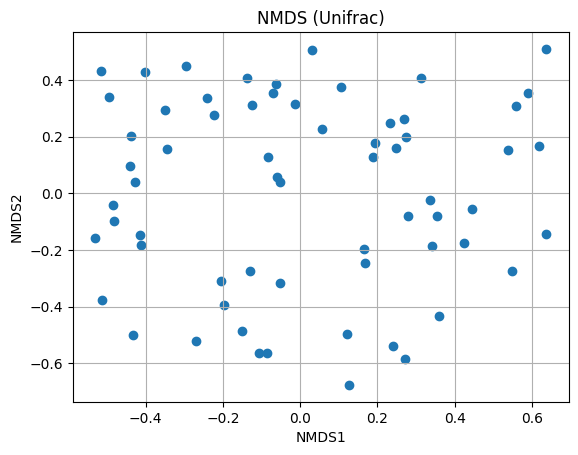

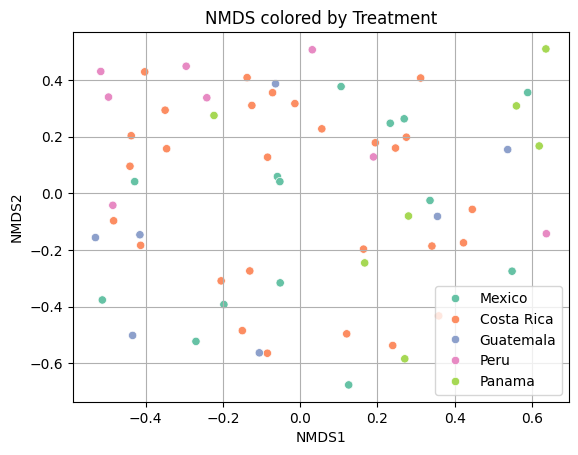

In [ ]:
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
# prompt: genera un dataframe de las distancias de full_dm con nombre de columna y renglon la muestra correspondiente

import pandas as pd
# Generate a pandas DataFrame from the distance matrix
full_dm_df = pd.DataFrame(full_dm.data, index=full_dm.ids, columns=full_dm.ids)

# Print the first few rows of the DataFrame
print(full_dm_df.head())
nmds = MDS(n_components=2, dissimilarity='precomputed', metric=False, random_state=42)
nmds_coords = nmds.fit_transform(full_dm_df.values)

plt.scatter(nmds_coords[:, 0], nmds_coords[:, 1])
plt.title("NMDS (Unifrac)")
plt.xlabel("NMDS1")
plt.ylabel("NMDS2")
plt.grid(True)
plt.show()
import seaborn as sns
valid_sample_names = full_dm_df.index.intersection(LatamMeta_df.index)
filtered_sample_df = LatamMeta_df.loc[valid_sample_names]
sns.scatterplot(x=nmds_coords[:, 0], y=nmds_coords[:, 1],
                hue=filtered_sample_df['country'], palette='Set2')
plt.title("NMDS colored by Treatment")
plt.xlabel("NMDS1")
plt.ylabel("NMDS2")
plt.legend()
plt.grid(True)
plt.show()

The subsequent `DistanceMatrix` object has support methods for pulling interesting sets of distances. Let's take a quick look at obtaining distances "within" a group, and contrast them to the distances "between" two groups.


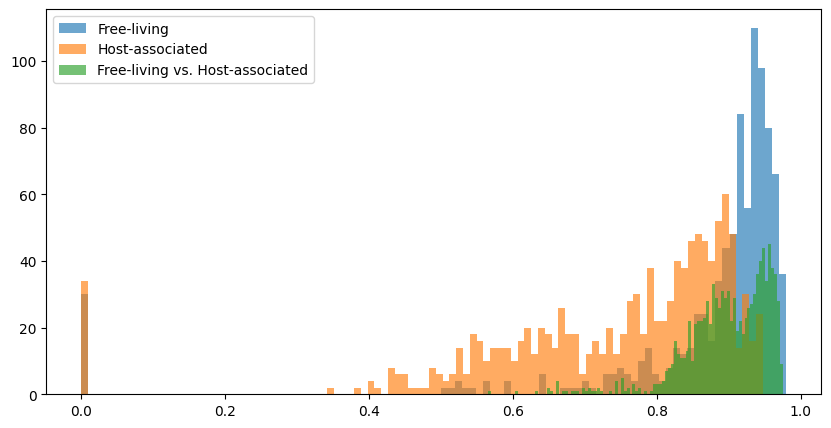

In [ ]:
plt.figure(figsize=(10, 5))

empo_1 = empo_1.loc[list(full_dm.ids)]

labels = []
for env in empo_1.unique():
    env_ids = set(empo_1[empo_1 == env].index)
    within_data = full_dm.within(env_ids)
    plt.hist(within_data['value'], alpha=0.65, bins=100)
    labels.append(env)

from_label, to_label = empo_1.unique()
from_ = empo_1[empo_1 == from_label].index
to_ = empo_1[empo_1 == to_label].index

between_data = full_dm.between(from_, to_)
plt.hist(between_data['value'], alpha=0.65, bins=100)
labels.append(f'{from_label} vs. {to_label}')

plt.legend(labels);

## PCoA and PERMANOVA

Let's now move on to [Principal Coordinates Analysis](https://en.wikipedia.org/wiki/Multidimensional_scaling#Classical_multidimensional_scaling) (PCoA). PCoA is a dimensionality reduction technique, which allows us to examine the primary axes of variation in a dataset. The scikit-bio implementation is based on [Legendre & Legendre](https://shop.elsevier.com/books/numerical-ecology/legendre/978-0-444-89249-2), but scikit-bio also supports an approximate version of PCoA, where the number of dimensions calculated is parameterized, and is scalable to quite large datasets.

As we'll see, the `OrdinationResults` object has a few member methods, including a `DataFrame` representation of the coordinate data.

In [ ]:
from skbio.stats.ordination import pcoa

In [ ]:
pc = pcoa(full_dm, number_of_dimensions=10)

In [ ]:
pc.proportion_explained

,0
PC1,0.144069
PC2,0.078315
PC3,0.054166
PC4,0.045531
PC5,0.032759
PC6,0.030761
PC7,0.030276
PC8,0.026213
PC9,0.025680
PC10,0.024309


In [ ]:
pc.samples.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
13114.jensen.43.s012,0.102599,-0.013186,0.051744,-0.268278,0.117142,0.121127,-0.127670,0.099653,-0.013086,-0.131704
13114.jensen.43.s013,0.167342,-0.051668,0.104860,-0.199222,0.078936,0.209755,-0.137936,-0.103807,0.017316,-0.136115
13114.jensen.43.s014,0.045551,-0.019912,0.082373,-0.267592,0.098775,0.133154,-0.136448,0.169821,0.092206,-0.022415
13114.pinto.63.s001,-0.301928,-0.091115,-0.035254,0.006271,-0.048121,-0.024585,0.006300,-0.014431,0.007390,-0.019744
13114.pinto.63.s002,-0.302759,-0.125877,0.023787,0.028098,0.053979,-0.048864,0.065205,-0.054087,-0.031639,0.056831


Using the coordinates, we can make a single scatter plot of the samples.

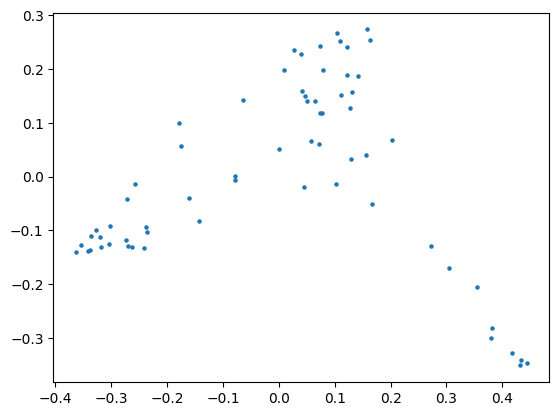

In [ ]:
plt.scatter(pc.samples['PC1'], pc.samples['PC2'], s=5);

...but that's not that interesting. Let's add some color. We're going to do this a couple of times so let's write a small function.

**NOTE**: We also recommend [EMPeror](https://academic.oup.com/gigascience/article/2/1/2047-217X-2-16/2656132) for large scale visualization. It is compatible with the `OrdinationResults` object, supports interactive operation and various brushing options.  

In [ ]:
def pcoa_plot(ord_result, metadata, category, title=None):
    plt.figure(figsize=(7, 7))

    # adjust the point size based on the number of samples
    if len(ord_result.samples) > 300:
        s = 5
    else:
        s = 10

    labels = []

    ord_ids = set(ord_result.samples.index)
    category_series = metadata.get_column(category).to_series()
    for env in category_series.unique():
        labels.append(env)

        env_ids = metadata.get_ids(where=f"[{category}] = '{env}'")
        env_ids = list(env_ids & ord_ids)

        plt.scatter(ord_result.samples.loc[env_ids, 'PC1'],
                    ord_result.samples.loc[env_ids, 'PC2'],
                    s=s, alpha=0.75)
    ax = plt.gca()
    ax.set_xlabel(f'PC1 ({100 * (ord_result.proportion_explained[0]):.2f}%)')
    ax.set_ylabel(f'PC2 ({100 * (ord_result.proportion_explained[1]):.2f}%)')
    plt.legend(labels)
    if title is not None:
        plt.title(title)

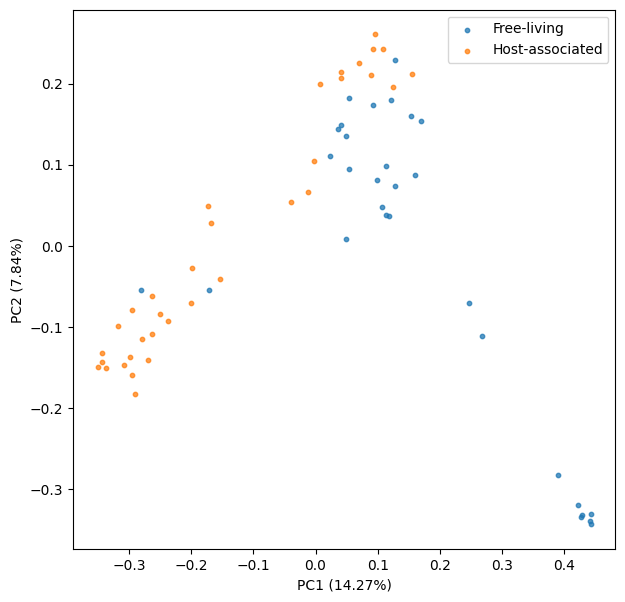

In [ ]:
pcoa_plot(pc, metadata, 'empo_1')

To support the above analyses, we will apply [PERMANOVA](https://onlinelibrary.wiley.com/doi/10.1111/j.1442-9993.2001.01070.pp.x) to the distances. PERMANOVA is a non-parametric analysis of variance. By default, PERMANOVA computes 999 permutations which is used to estimate the p-value.

In [ ]:
from skbio.stats.distance import permanova

In [ ]:
permanova(full_dm, empo_1)
#pseudo F is the same thanin Anova, If F is larger than 1, then the groups are different

,PERMANOVA results
method name,PERMANOVA
test statistic name,pseudo-F
sample size,64
number of groups,2
test statistic,5.670182
p-value,0.001
number of permutations,999


## Exercise # 1 Generate a Unifrac visualization with empo_2

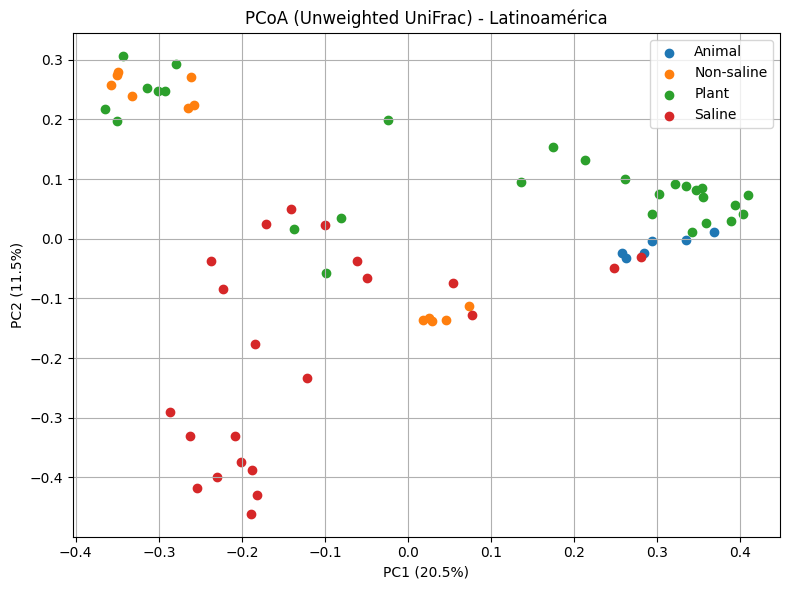

In [ ]:
# 6. Extraer matriz de datos
# Transpose the data array to have shape (number of samples, number of features)
data = tableShotgun.matrix_data.toarray().T  # Transpose the data array
sample_ids = tableShotgun.ids(axis='sample')
feature_ids = tableShotgun.ids(axis='observation') #This is the taxa argument

# 7. Calcular UniFrac (no ponderado)
unifrac_unweighted = beta_diversity(
    metric='unweighted_unifrac',
    counts=data,
    ids=sample_ids,
    tree=phylogeny,
    taxa=feature_ids #Adding the taxa argument
)

# 8. PCoA
pcoa_results = pcoa(unifrac_unweighted)
df_coords = pcoa_results.samples
df_coords['sample_id'] = df_coords.index

# 9. Unir coordenadas con metadata
merged = df_coords.join(LatamMeta_df, how='inner')

# 10. Visualizar PCoA con color
plt.figure(figsize=(8, 6))
for variable, group in merged.groupby('empo_2'):
    plt.scatter(group['PC1'], group['PC2'], label=variable)

plt.xlabel(f"PC1 ({round(pcoa_results.proportion_explained[0]*100, 1)}%)")
plt.ylabel(f"PC2 ({round(pcoa_results.proportion_explained[1]*100, 1)}%)")
plt.title("PCoA (Unweighted UniFrac) - Latinoamérica")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Extra material. Incorporating phylogeny in Mantel test

###Label your phylogeny

In [ ]:
#labeled_phylogeny=phylogeny
labeled_phylogeny=labeled_phylogeny.shear(set(even_table.ids(axis='observation')))

In [ ]:
# prompt: generate the metadata path by joining github_data_path with "emp500/sample.tsv"
latamtax_path = github_data_path + "shotgun/latam_ogu.tax"
# Read the TSV file directly from the URL into a pandas DataFrame
tax_df = pd.read_csv(latamtax_path, sep='\t', low_memory=False, header=None,index_col=0)
taxonomy_dict = tax_df[1].to_dict()
tax_df.head()

,1
0,
G000005825,d__Bacteria; p__Firmicutes; c__Bacilli; o__Bac...
G000006175,d__Archaea; p__Methanobacteriota_A; c__Methano...
G000006605,d__Bacteria; p__Actinobacteriota; c__Actinomyc...
G000006725,d__Bacteria; p__Proteobacteria; c__Gammaproteo...
G000006745,d__Bacteria; p__Proteobacteria; c__Gammaproteo...


In [ ]:
# prompt: print first 5 elements on phylum_dict

from itertools import islice
for key, value in islice(taxonomy_dict.items(), 5):
    print(f'{key}: {value}')

G000005825: d__Bacteria; p__Firmicutes; c__Bacilli; o__Bacillales_H; f__Bacillaceae_D; g__Bacillus_S; s__Bacillus_S pseudofirmus
G000006175: d__Archaea; p__Methanobacteriota_A; c__Methanococci; o__Methanococcales; f__Methanococcaceae; g__Methanococcus; s__Methanococcus voltae_A
G000006605: d__Bacteria; p__Actinobacteriota; c__Actinomycetia; o__Mycobacteriales; f__Mycobacteriaceae; g__Corynebacterium; s__Corynebacterium jeikeium
G000006725: d__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Xanthomonadales; f__Xanthomonadaceae; g__Xylella; s__Xylella fastidiosa
G000006745: d__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacterales; f__Vibrionaceae; g__Vibrio; s__Vibrio cholerae


In [ ]:
# --- Step 3: Attach taxonomy to tips ---
for tip in labeled_phylogeny.tips():
    #print(tip.name)
    if tip.name in taxonomy_dict:
        lineage = [level.strip() for level in taxonomy_dict[tip.name].split(';')]
        #print(lineage)
        tip.lineage = lineage  # store it as a custom attribute
        #print(tip.lineage)

    else:
        tip.lineage = []

In [ ]:
# --- Step 4: Recursively assign taxonomy to internal nodes ---
def assign_taxonomy(node):
    if node.is_tip():
        return node.lineage

    child_lineages = [assign_taxonomy(child) for child in node.children]

    # Find shared lineage prefix
    common = []
    for levels in zip(*child_lineages):
        if all(l == levels[0] for l in levels):
            common.append(levels[0])
        else:
            break

    node.lineage = common
    if common:
        node.name = common[-1]  # Assign the most specific shared level
    return common

assign_taxonomy(labeled_phylogeny)

[]

In [ ]:


from io import StringIO

# Get Newick string
output = StringIO()
labeled_phylogeny.write(output, format='newick')
newick_str = output.getvalue()
print(newick_str)

(((G900012635:0.55887,(G009787175:0.7282830000000001,((G005877295:0.161462,((G000484935:0.050263,(G000399765:0.035982,G000402075:0.020854)'g__Nitrosopelagicus':0.021156)'g__Nitrosopelagicus':0.145281,(G000220175:0.073388,((G000299365:0.053246,G000746765:0.056244999999999996)'g__Nitrosopumilus':0.042513999999999996,(G002317795:0.078934,G001437625:0.09220300000000001)'g__Nitrosopumilus':0.041338)'g__Nitrosopumilus':0.026518)'f__Nitrosopumilaceae':0.107898)'f__Nitrosopumilaceae':0.08816199999999999)'f__Nitrosopumilaceae':0.108549,G000802205:0.39495)'o__Nitrososphaerales':0.287321)'p__Thermoproteota':0.105016)'d__Archaea':0.063781,(((((G004765805:0.197897,G900103505:0.185548)'o__Halobacteriales':0.032076,((G000470655:0.179979,G000755225:0.160387)'f__Haloarculaceae':0.01989,G009184555:0.17960399999999999)'f__Haloarculaceae':0.050626000000000004,(G000427685:0.153602,(G000283335:0.109833,((G000336755:0.05091,(G001469865:0.049334,G000025685:0.058424)'g__Haloferax':0.014467)'g__Haloferax':0.055

In [ ]:
# prompt: find in tree a name that contain G000006605 but is not equal to G000006605

# Iterate through all nodes in the tree
for node in labeled_phylogeny.levelorder(include_self=True):
    # Check if the node name contains the substring and is not equal to the substring
    if 'G000315565' in node.name: #and node.name != 'G000006605':
      #phylum = taxonomy.split(";")[1].strip()
      print(node.name)


G000315565


In [ ]:
labeled_phylogeny
print(labeled_phylogeny.find('G000315565').parent.parent.ascii_art())

          /-G000346485
-f__Nostocaceae
         |          /-G000315565
          \f__Nostocaceae
                   |          /-G000817735
                    \f__Nostocaceae
                              \-G000828075


NameError: name 'first_pc' is not defined

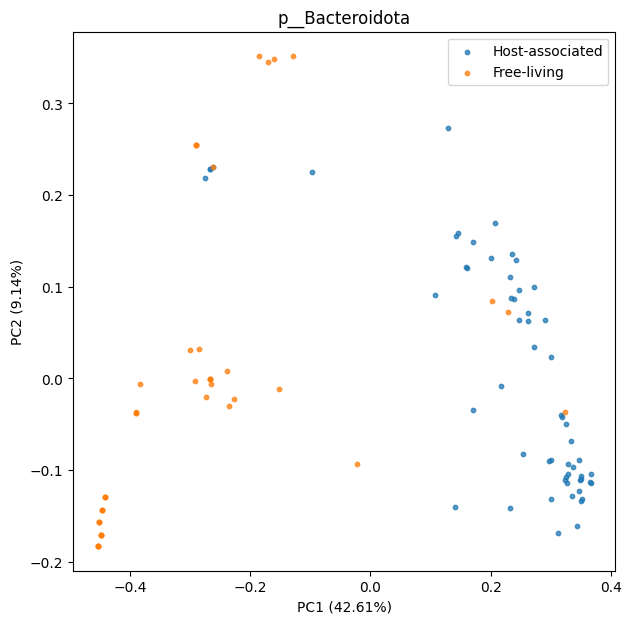

### Incorporating phylogeny

Now, let's tinker.

We might wonder whether the sample-to-sample relationships are consistent when constrained to particular phyla.

To do this, we're going to aggregate sample information up the phylogeny (from tip to root). Specifically, we are going to determine the set of samples a feature is present in, and then push the unique sample IDs up the tree through a postorder traversal, effecively reducing the information.

While doing so, we are also going to cache the names of the features found within a clade simply to facilitate filtering later on.



In [ ]:
latamtree_path = github_data_path + "latam/shotgun/latam_ogu.nwk"
labeled_phylogeny = skbio.TreeNode.read(latamtree_path, format='newick')
labeled_phylogeny

<TreeNode, name: N1, internal node count: 14326, tips count: 14933>

Postorder means children are assured to be evaluted before parents. The TreeNode supports many types of traversals, and pleasant examples of common traversals can be found on [Wikipedia](https://en.wikipedia.org/wiki/Tree_traversal). Here, we will decorate these new attributes onto the tree.

The algorithm is:
1. if the object being evaluated is a tip
* get the samples represented (or the empty set)
* construct a set composed of only the feature name
2. else the object must be an internal node
* compute the set union of samples represented
* compute the set union of features represented

In [ ]:
from functools import reduce
from operator import or_

In [ ]:
sample_ids = even_table.ids()

# this complex dict comprehension maps a feature ID to the set of
# samples that feature was found it. The v.indices attribute is the
# index positions of the nonzero values within a SciPy sparse vector
samples_represented = {id_: set(sample_ids[v.indices])
                       for v, id_, _ in even_table.iter(axis='observation', dense=False)}

In [ ]:
for node in labeled_phylogeny.postorder():
    if node.is_tip():
        node.samples_represented = samples_represented.get(node.name, set())
        node.tips_represented = {node.name, }
    else:
        node.samples_represented = reduce(or_, [child.samples_represented for child in node.children])
        node.tips_represented = reduce(or_, [child.tips_represented for child in node.children])

Let's spot check what the representation is at the domain level.

In [ ]:
for child in labeled_phylogeny.children:
    print(f"Samples with {child.name}: {len(child.samples_represented)}")

Samples with d__Archaea: 63
Samples with d__Bacteria: 64


Next, let's gather all phylum level named nodes (p__), sort them by how many samples are represented, and print the top few

In [ ]:
from operator import itemgetter

In [ ]:
for n in labeled_phylogeny.traverse():
  if n.name is not None and n.name.startswith('p__'):
    print(n.name)

p__Thermoproteota
p__Halobacteriota
p__Chloroflexota
p__Chloroflexota
p__Chloroflexota
p__Actinobacteriota
p__Actinobacteriota
p__Actinobacteriota
p__Firmicutes_A
p__Firmicutes_B
p__Elusimicrobiota
p__Bacteroidota
p__Bacteroidota
p__Planctomycetota
p__Planctomycetota
p__Planctomycetota
p__Planctomycetota
p__Myxococcota
p__Acidobacteriota
p__Acidobacteriota
p__Acidobacteriota
p__Acidobacteriota
p__Acidobacteriota
p__Acidobacteriota
p__SAR324
p__Proteobacteria
p__Desulfobacterota
p__Spirochaetota
p__Patescibacteria


In [ ]:
named_nodes = [(n.name, len(n.samples_represented), n)
               for n in labeled_phylogeny.traverse()
               if n.name is not None and n.name.startswith('p__')]

named_nodes = sorted(named_nodes, key=itemgetter(1), reverse=True)
for name, count, _ in named_nodes[:10]:
    print(f"Samples with {name}: {count}")

Samples with p__Actinobacteriota: 64
Samples with p__Actinobacteriota: 64
Samples with p__Actinobacteriota: 64
Samples with p__Bacteroidota: 64
Samples with p__Bacteroidota: 64
Samples with p__Planctomycetota: 64
Samples with p__Planctomycetota: 64
Samples with p__Proteobacteria: 64
Samples with p__Firmicutes_A: 62
Samples with p__Desulfobacterota: 59


In [ ]:
named_nodes

[('p__Actinobacteriota',
  64,
  <TreeNode, name: p__Actinobacteriota, internal node count: 264, tips count: 273>),
 ('p__Actinobacteriota',
  64,
  <TreeNode, name: p__Actinobacteriota, internal node count: 255, tips count: 263>),
 ('p__Actinobacteriota',
  64,
  <TreeNode, name: p__Actinobacteriota, internal node count: 249, tips count: 257>),
 ('p__Bacteroidota',
  64,
  <TreeNode, name: p__Bacteroidota, internal node count: 123, tips count: 126>),
 ('p__Bacteroidota',
  64,
  <TreeNode, name: p__Bacteroidota, internal node count: 122, tips count: 125>),
 ('p__Planctomycetota',
  64,
  <TreeNode, name: p__Planctomycetota, internal node count: 17, tips count: 20>),
 ('p__Planctomycetota',
  64,
  <TreeNode, name: p__Planctomycetota, internal node count: 13, tips count: 16>),
 ('p__Proteobacteria',
  64,
  <TreeNode, name: p__Proteobacteria, internal node count: 614, tips count: 643>),
 ('p__Firmicutes_A',
  62,
  <TreeNode, name: p__Firmicutes_A, internal node count: 33, tips count: 

In [ ]:
# A helper function to intersect a table with the features represented by a node

def intersect_with_node(tab, node):
    tips_in_table = set(tab.ids(axis='observation'))
    tipset = node.tips_represented & tips_in_table
    return tab.filter(tipset, axis='observation', inplace=False).remove_empty()

Now we will take two interesting sets. While testing this notebook, it was noted the number of sample IDs in common between Proteobacteria and Firmicutes_D, after rarefaction, was relatively low. So instead, let's look at Proteobacteria and Bacteroidota.

The next few cells filter the feature table to each phyla of focus, constrain them to the exact same set of IDs, compute UniFrac again, and then principal coordinates.

In [ ]:
first_name, _, first_node = named_nodes[0]
second_name, _, second_node = named_nodes[2]



In [ ]:
even_table_first = intersect_with_node(tableShotgun, first_node).subsample(depth)
even_table_second = intersect_with_node(tableShotgun, second_node).subsample(depth)

In [ ]:
common_ids = set(even_table_first.ids()) & set(even_table_second.ids())
even_table_first = even_table_first.filter(common_ids).remove_empty()
even_table_second = even_table_second.filter(common_ids).remove_empty()

In [ ]:
first_dm = beta_diversity('unweighted_unifrac', even_table_first, tree=phylogeny)
second_dm = beta_diversity('unweighted_unifrac', even_table_second, tree=phylogeny)

In [ ]:
first_pc = pcoa(first_dm, number_of_dimensions=10)
second_pc = pcoa(second_dm, number_of_dimensions=10)

Now we can visualize these clade specific beta diversity calculations!

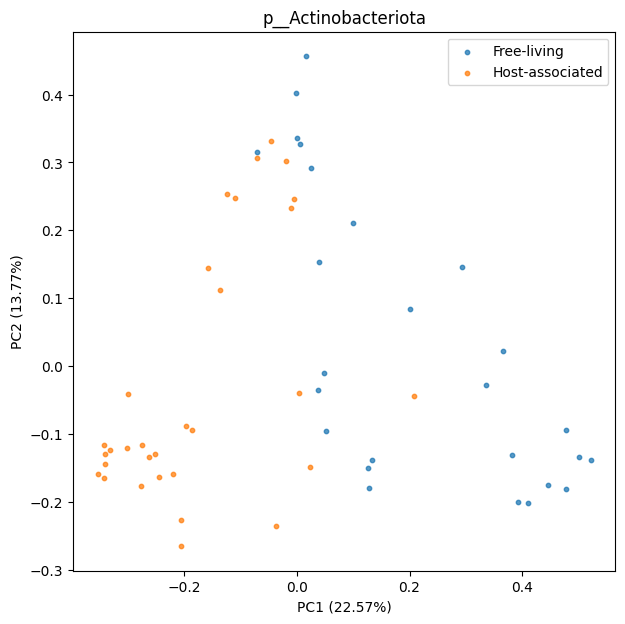

In [ ]:
pcoa_plot(first_pc, metadata, 'empo_1', first_name)

In [ ]:
pcoa_plot(second_pc, metadata, 'empo_1', second_name)

### Mantel test

We additionally can compute the correlation of the sample-sample relationships in both phyla using a [Mantel](https://pubmed.ncbi.nlm.nih.gov/6018555/) test. Mantel, like PERMANOVA, is non-parametric and by default uses 999 repetitions to estimate a p-value.

In the next few cells, we will compare Proteobacteria to Bacteroidota, Proteobacteria to the full tree, and Bacteroidota to the full tree. We then will apply PERMANOVA to these clade specific distance matrices.

Interestingly, we observe a relatively low correlation between these two phyla, and it seems the sample-sample relationships within Bacteroidota better recapitulate the full distance matrix. This observation is further supported by the relative difference in test statistics from PERMANOVA, where the statistic is larger between host and non-host samples.

In [ ]:
from skbio.stats.distance import mantel

In [ ]:
r, p, _ = mantel(first_dm, second_dm)
print(f"Mantel r={r:0.2} p={p:0.2}")

Mantel r=0.89 p=0.001


In [ ]:
r, p, _ = mantel(full_dm, first_dm, strict=False)
print(f"Mantel r={r:0.2} p={p:0.2}")

Mantel r=0.75 p=0.001


In [ ]:
r, p, _ = mantel(full_dm, second_dm, strict=False)
print(f"Mantel r={r:0.2} p={p:0.2}")

Mantel r=0.77 p=0.001


In [ ]:
permanova(first_dm, empo_1)

,PERMANOVA results
method name,PERMANOVA
test statistic name,pseudo-F
sample size,56
number of groups,2
test statistic,8.822204
p-value,0.001
number of permutations,999


In [ ]:
permanova(second_dm, empo_1)

,PERMANOVA results
method name,PERMANOVA
test statistic name,pseudo-F
sample size,56
number of groups,2
test statistic,7.960979
p-value,0.001
number of permutations,999


### Proscrustes disparity

And last, we will compute the [Procrustes disparity](https://en.wikipedia.org/wiki/Procrustes_analysis), a measure of fit, between the clade specific ordinations.

Procrustes can also be permuted to estimate a p-value, however that is not directly supported at this time within scikit-bio. The procedure is relatively simple though: iterate N times, randomly shuffle the IDs of one of the matrices, recomptue Procrustes. This too is slated for inclusion directly in scikit-bio. And last, the EMPeror library (noted above) can plot Procrustes transforms linking the samples in both ordinations visually.

In [ ]:
from scipy.spatial import procrustes

In [ ]:
mtx1, mtx2, disparity = procrustes(
    first_pc.samples[['PC1', 'PC2']],
    second_pc.samples[['PC1', 'PC2']]
)
print(disparity)